# Prospecção de Dados (Data Mining) DI/FCUL - HA1

## First Home Assignement (MC/DI/FCUL - 2024)

### Fill in the section below

### GROUP:`5`

* Paulo Lopes, 54348 - 3
* Simona Losco, 62523 - 3
* Sona Moravcikova, 62932 - 3




The purpose of this Home Assignment is
* Read a Data file with a Set of Texts
* Compute similarities between texts
* Perform simple classification of texts using a Naive Bayes classifier

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**


## 1. Read the Dataset

The dataset is the file `Sentences_75Agree.txt` from the [Financial Sentiment Analysis database on Gugging Face](https://huggingface.co/datasets/financial_phrasebank)

* Read the dataset and separate them by unique documents (one document per line)
* The last word of each document is the class and it **must be removed from the document** but kept separate for use in the classification tasks below
    * classes can be `.@positive`, `.@negative`, `.@neutral`
    


In [52]:
text=open("Sentences_75Agree.txt", "rt", encoding="latin-1").readlines()
documents = []  
classes = []

for sentence in text:
    words = sentence.strip().split("@")
    class_label = words[-1]
    document = ' '.join(words[:-1])   
    documents.append(document)
    classes.append(class_label)


## 2. Compute similarities between texts

* Compute the TF.IDF of all words in texts
* compute the average similarity beween texts
* Plot the document similarity distribution (suggestion use [boxplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html) or [histograms](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) or  [histograms with density](https://matplotlib.org/stable/gallery/statistics/histogram_features.html))
* Comment your results


In [59]:
### Supporting functions
import unicodedata
from math import log2
import numpy as np
import matplotlib.pyplot as plt

def basic_word_tokenizer(text):
    return text.split()

def remove_accents(s):
    nfkd_form = unicodedata.normalize('NFKD', s)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

def remove_stuff(s):
    for c in "\\\t0123456789Ææœ—‘’\ufeff{|}“”.,()$£%&[]?@#!=;*+–\"ǁ":
        s=s.replace(c, "")
    s=s.replace("-", " ")
    return s

def get_words_from_corpus(corpus):
    words_texts=[]
    for i,text in enumerate(corpus):
        text=text.strip().lower()
        text=remove_accents(text)
        text=remove_stuff(text)
        text=text.lower()
        words = basic_word_tokenizer(text)
        words_texts.append(words)
    return words_texts

def calc_all_words(words_text_sets):
    all_words=set()
    for words in words_text_sets: all_words |= words
    return all_words

def word_counter(words):
    #1. get uniques
    unique_words=set(words)
    #2. make a dictionary for counting
    D=dict(zip(unique_words, [0]*len(unique_words)))
    #3. count all
    for w in words: D[w]+=1
    return D  

def TF(word_counts):
    #get the counts
    counts  = word_counts.values()
    if len(counts)==0: return {}
    the_max = max(counts)   #compute the maximum
    #return a dictionary that for each word returns the ratio of wc/max_wc
    return dict(zip(word_counts.keys(), [c/the_max for c in counts]))

def calc_tfs(words_texts):
    all_tfs=[]
    for words in words_texts:
        wcounts = word_counter(words)
        all_tfs.append(TF(wcounts))
    return all_tfs


def IDF(all_words, doc_word_counts):
    #first initialize a new dictionary with one entry for each word
    D=dict(zip(all_words, [0]*len(all_words)))
    N=len(doc_word_counts)
    for doc in doc_word_counts:
        for word in doc: D[word]+=1
    return {w: log2(N/D[w]) for w in D}

def cosine_similarity_tfidf(idx1, idx2, words_text_sets, all_tfs, idfs):
    text1= words_text_sets[idx1]
    text2= words_text_sets[idx2]
    tfs1=all_tfs[idx1]
    tfs2=all_tfs[idx2]

    common_words = text1 & text2
    if len(common_words)==0: return 0.0
    common_tfidfs = [tfs1[w]*tfs2[w]*idfs[w]*idfs[w] for w in common_words]

    #squared tfidfs
    tfidfs2_1=np.array([tfs1[w]*idfs[w] for w in text1])**2
    tfidfs2_2=np.array([tfs2[w]*idfs[w] for w in text2])**2

    return sum(common_tfidfs)/(np.sqrt(tfidfs2_1.sum())*np.sqrt(tfidfs2_2.sum()))
 
def text_similarities2(words_text_sets, all_tfs, idfs):
    N=len(words_text_sets)
    sims=[]
    for i in range(N-1):
        for j in range(i+1, N):
            sim = cosine_similarity_tfidf(i,j, words_text_sets, all_tfs, idfs)
            sims.append((sim, (i,j)))
    return sims

Average similarity between texts: 0.017873423091382176


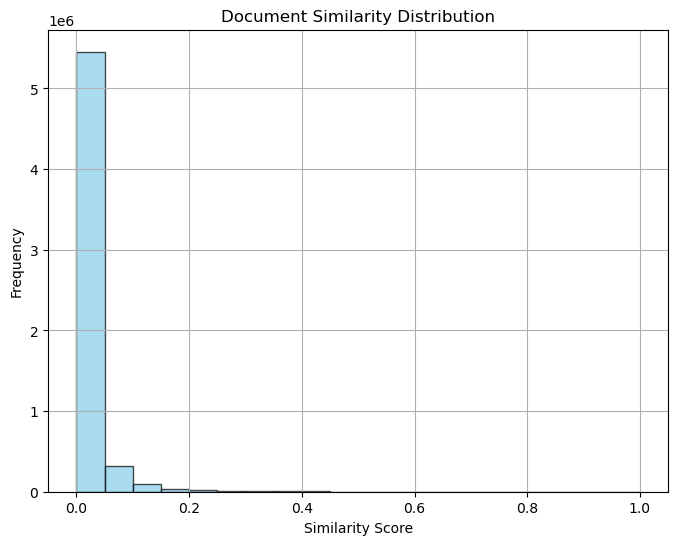

Similarity: 1.0
The Group 's consolidated net sales for 2008 totaled 3.4 billion euros and it employs approximately 13,000 persons .
The Group 's consolidated net sales for 2009 totaled 1.5 billion euros and it employs approximately 10,000 persons .


In [64]:
### Processing code
words_texts = get_words_from_corpus(documents)
words_text_sets = [set(words) for words in words_texts]
all_words       = calc_all_words(words_text_sets)

all_tfs = calc_tfs(words_texts)
idfs = IDF(all_words, words_text_sets)
sims = text_similarities2(words_text_sets, all_tfs, idfs)
average_similarity = np.mean([sim[0] for sim in sims])

print("Average similarity between texts:", average_similarity)

# Extract similarity scores from sims list
similarity_scores = [sim[0] for sim in sims]

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(similarity_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Document Similarity Distribution')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

idxs = np.array(similarity_scores).argsort()[::-1]
p1, p2 = sims[idxs[10]][1]
print("Similarity:", sims[idxs[10]][0])
print(documents[p1])
print(documents[p2])

### Short analysis

The average similarity between texts we got from the analyis is quite low which suggests the texts in the database are quite different. However this can be due to multiple reasons apart from the fact that they are actually talking about different things. We have noticed that the the different texts use different words for the same meaning for example these words increases - went up - raised - jumped - grew - rose all mean the same thing in this context but are not calssified as the same thing in our analysis since we used cosine similarity which uses only the word counts so this can be one of the reasons why the average similarity score is low. Another explanation of the score being low could be that the different documents in this text came from different sources - some of them look like they have been generated by a computer while others look like they have been written by a person. We have also noticed that there are multiple texts that have a similarity of 1.0 (example above) which look like computer generated messages with just different values which also influence the the average similarity score.

## 3. Make a Naive Bayes Classifier 

* Split dataset randomly into training and testing (20% for testing)
* Train a Naive Bayes Model and do some sensitivity analyis on the hyperparameters 
* Evaluate your results with the testing set


In [73]:
### Supporting functions

from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix, precision_score, recall_score
from random import sample, shuffle
import pandas as pd

def make_train_test(X, y, r=0.25 ):
    N=len(X)
    test_idx  = set(sample(range(N), int(N*r)))
    train_idx = list(set(range(N)) - test_idx)
    test_idx =list(test_idx)
    shuffle(train_idx)
    shuffle(test_idx)
    train_set_X = [X[i] for i in train_idx]
    train_set_y = [y[i] for i in train_idx]
    test_set_X = [X[i] for i in test_idx]
    test_set_y = [y[i] for i in test_idx]
    return train_set_X, train_set_y, test_set_X, test_set_y

def calc_prior_counts(labels):
    yv, yc=np.unique(labels, return_counts=True)
    priors=np.ones(len(yv))
    priors[yv]=yc
    return priors


def init_likelihood_counts(docs_words, n_labels):
    all_words=calc_all_words(docs_words)
    L_hoods={}
    for w in all_words:
        L_hoods[w]=np.zeros(n_labels)
    return L_hoods

def update_likelihood_counts(L_hoods, words, label):
    for word in words: 
        L_hoods[word][label]+=1

def calc_likelihood_counts(docs_words, labels):
    n_labels=len(set(labels)) #!!! <- not very bright!
    L_hoods = init_likelihood_counts(docs_words, n_labels)
    for i, words in enumerate(docs_words): 
        update_likelihood_counts(L_hoods, words, labels[i])
    return L_hoods

def classify_new_document(words, priors, L_hoods, alpha=0):
    res=priors/priors.sum()
    alpha_vec=np.ones(len(res))*alpha
    for word in words:
        if word in L_hoods: 
            res*=(L_hoods[word]/L_hoods[word].sum() + alpha_vec)
    return res/res.sum()

def classify_documents(docs, priors, L_hoods, alpha=0):
    return [classify_new_document(words, priors, L_hoods, alpha).argmax(axis=0) for words in docs]

def sensitivity_anal(train_docs, train_class, test_docs, test_class, alphas):

    f1s = []
    Mccs = []
    precs = []
    recs = []

    pc = calc_prior_counts(train_class)
    lhc = calc_likelihood_counts(train_docs, train_class)
    for alpha in alphas:
        print("Alpha:", alpha)
        preds = classify_documents(test_docs, PC, LHC, alpha=alpha)
        f1s.append(f1_score(test_class, preds, average="weighted"))
        Mccs.append(matthews_corrcoef(test_class, preds))
        precs.append(precision_score(test_class, preds, average="weighted"))
        recs.append(recall_score(test_class, preds, average="weighted"))
        print("Confusion matrix:")
        print(confusion_matrix(test_class, preds))
    return f1s, Mccs, precs, recs


Class counts
0    2146
1     887
2     420
dtype: int64

Alpha: 0.0001
Confusion matrix:
[[421  10   1]
 [ 95  76   0]
 [ 58  18  11]]
Alpha: 0.001
Confusion matrix:
[[421  10   1]
 [ 94  77   0]
 [ 58  19  10]]
Alpha: 0.01
Confusion matrix:
[[425   7   0]
 [100  71   0]
 [ 58  22   7]]
Alpha: 0.1
Confusion matrix:
[[427   5   0]
 [111  60   0]
 [ 63  23   1]]
Alpha: 1
Confusion matrix:
[[432   0   0]
 [132  39   0]
 [ 80   7   0]]
Alpha: 10
Confusion matrix:
[[432   0   0]
 [171   0   0]
 [ 87   0   0]]


/Users/sonamoravcikova/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sonamoravcikova/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


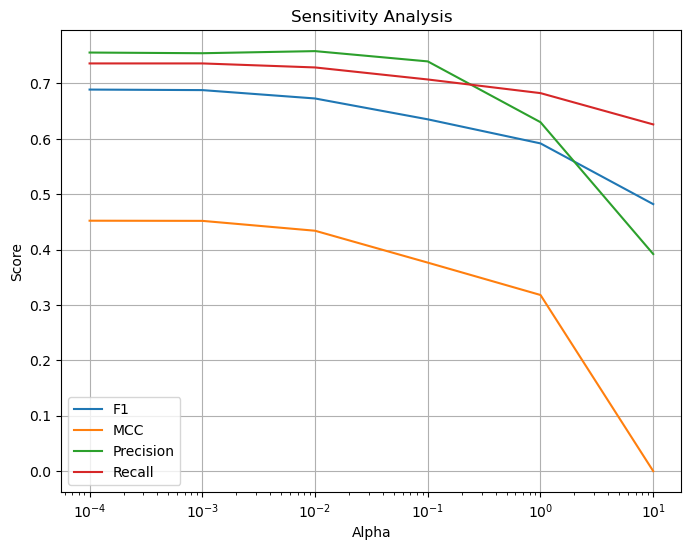

In [77]:
### Processing code 
class_vs, class_labels = pd.factorize(classes)
train_docs, train_classes, test_docs, test_classes = make_train_test(words_text_sets, class_vs, r=0.2)

PC = calc_prior_counts(train_classes)
LHC=calc_likelihood_counts(train_docs, train_classes)

preds=classify_documents(test_docs, PC, LHC, alpha=0.0001)

print("Class counts")
print(pd.Series(class_vs).value_counts())
print()

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
f1s, Mccs, precs, recs = sensitivity_anal(
    train_docs, train_classes, test_docs, test_classes, alphas
)

plt.figure(figsize=(8, 6))
plt.plot(alphas, f1s, label="F1")
plt.plot(alphas, Mccs, label="MCC")
plt.plot(alphas, precs, label="Precision")
plt.plot(alphas, recs, label="Recall")
plt.title("Sensitivity Analysis")
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

## 4. Discussion of findings 

* Comment your results above
* Discuss how could they be used in a Big Data environment

Alpha is the smoothing factor so as we increase the alpha the model starts predicting everything to be the most common class - in our case the @neutral. So, from the results above we can see that the performance of the model decreases as we increase alpha because it becomes too smooth. For the lower values of alpha this model seems to be a pretty good classifier even with our unbalanced dataset. 

These results could be used in big data for automatically analyzing sentiments in large volumes of text data such as social media posts or news articles which would give businesses insights into customer opinions, market trends or filtering inappropriate content. This model is appropriate to use in big data because its fast and updatable which is very useful from a big data perspective as it will get better with more and more data.  
